In [1]:
using Random, DelimitedFiles, PyPlot, StatsBase

Load reference data and define plotting
(this will change after Przemek prepares better visualization)

In [2]:
loc = readdlm("loc.txt")

153×2 Array{Float64,2}:
 -79.2909  43.7837
 -79.0132  43.8662
 -79.8246  44.1615
 -83.109   42.0969
 -80.0141  43.1983
 -79.4112  44.015 
 -75.742   45.2714
 -79.6861  44.3328
 -79.7098  44.4104
 -77.3964  44.1944
 -79.7113  43.864 
 -78.7147  43.9102
 -79.2925  45.0493
   ⋮              
 -79.5551  43.8455
 -82.385   42.5862
 -80.0065  44.5249
 -79.9096  43.3162
 -80.5485  43.509 
 -80.5151  43.4696
 -79.2294  43.0148
 -78.9597  43.9174
 -83.011   42.2707
 -82.9424  42.314 
 -79.6284  43.7861
 -80.7346  43.1151

In [3]:
dist = readdlm("distkm.txt")

153×153 Array{Float64,2}:
   0.0      25.5691   81.8831  388.798   …  366.945    32.1738  147.782 
  25.1537    0.0     102.777   413.394      391.541    56.0079  172.378 
  82.3007  103.224     0.0     399.893      378.04     50.7209  158.877 
 388.747   413.54    399.865     0.0         36.9392  367.115   241.551 
  96.4183  117.187   129.688   303.684      281.831    82.3623   62.6679
  31.5325   50.8019   52.7316  406.836   …  384.982    39.8438  165.82  
 359.209   334.3     401.386   745.918      724.065   381.755   504.902 
  83.9051  104.139    29.3792  428.76       406.907    65.2319  187.744 
  89.3415  109.575    36.8667  436.247      414.394    72.7194  195.231 
 163.578   138.978   238.802   551.408      529.554   194.986   310.392 
  44.8736   67.9438   38.4316  371.541   …  349.688    13.2937  130.525 
  50.7736   25.6199  125.444   438.685      416.832    81.6278  197.669 
 166.597   149.768   124.579   523.959      502.106   160.431   282.943 
   ⋮                     

In [4]:
function plot_tour(t, loc)
    t2 = [t; t[1]]
    plot(loc[t2, 1], loc[t2, 2])
end

plot_tour (generic function with 1 method)

Tour length calculation function common for all algorithms

In [5]:
function eval_tour(tour, d)
    travel = d[tour[end], tour[1]]
    for i in 2:length(tour)
        travel += d[tour[i-1], tour[i]]
    end
    travel
end

eval_tour (generic function with 1 method)

Random initial tour generation common for all algorithms

In [6]:
init_tour(n) = randperm(n)

init_tour (generic function with 1 method)

Function choosing one random neighbor used in local search and SANN

In [7]:
function pick_neighbor(tour, prob)
    neighbor = copy(tour)

    x, y = rand(eachindex(tour), 2)
    if x != y
        if rand() < prob
            x,y = minmax(x,y)
            reverse!(@view neighbor[x:y])
        else
            tmp = neighbor[x]
            if x < y
                neighbor[x:y-1] = @view neighbor[x+1:y]
            else
                neighbor[y+1:x] = @view neighbor[y:x-1]
            end
            neighbor[y] = tmp
        end
    end
    return neighbor
end

pick_neighbor (generic function with 1 method)

Local search routine

In [8]:
function localsearch(dist, iter, prob)
    t = init_tour(size(dist, 1))
    v = eval_tour(t, dist)
    best_t, best_v = t, v
    for i in 1:iter
        newt = pick_neighbor(t, prob)
        newv = eval_tour(newt, dist)
        if newv < v
            t, v = newt, newv
            if v < best_v
                best_v, best_t = v, t
            end
        end
    end
    (best_v, best_t)
end

localsearch (generic function with 1 method)

In [9]:
alg_localsearch(;iter=10^7, prob=0.8) = (x -> localsearch(x, iter, prob), "Local search (iter=$iter, prob=$prob)")

alg_localsearch (generic function with 1 method)

Simulated annealing routine

In [10]:
function sann(dist, T0, Tf, α, iter, prob)
    T = T0
    t = init_tour(size(dist, 1))
    v = eval_tour(t, dist)
    best_t, best_v = t, v
    while T >= Tf
        for i in 1:iter
            newt = pick_neighbor(t, prob)
            newv = eval_tour(newt, dist)
            if newv < v || rand() < exp(-(newv - v) / T)
                t, v = newt, newv
                if v < best_v
                    best_v, best_t = v, t
                end
            end
        end
        T *= α
    end
    (best_v, best_t)
end

sann (generic function with 1 method)

In [11]:
alg_sann(; T0=1, Tf=0.001, α=0.9, iter=round(10^7 * log(α)/ log(Tf/T0)), prob=0.8) =
    (x -> sann(x, T0, Tf, α, iter, prob), "SANN (T0=$T0, Tf=$Tf, α=$α, iter=$iter, prob=$prob)")

alg_sann (generic function with 1 method)

Genetic algorithm routine

In [12]:
function init_tour_ga(d)
    t = randperm(size(d, 1))
    (eval_tour(t, d), t)
end

init_tour_ga (generic function with 1 method)

In [13]:
function mutate(tour, d)
    x, y = minmax(rand(eachindex(tour[2]), 2)...)
    reverse!(@view tour[2][x:y])
    return (eval_tour(tour[2], d), tour[2])
end

mutate (generic function with 1 method)

In [14]:
function crossover(t1, t2, d)
    x, y = minmax(rand(eachindex(t1[2]), 2)...)
    child = similar(t1[2])
    used = Set{Int}()
    for i in x:y
        child[i] = t1[2][i]
        push!(used, t1[2][i])
    end
    pos = 1
    for j in eachindex(t2[2])
        if pos == x
            pos = y + 1
        end
        if !(t2[2][j] in used)
            child[pos] = t2[2][j]
            pos += 1
        end
    end
    (eval_tour(child, d), child)
end

crossover (generic function with 1 method)

In [15]:
function ga(dist, popsize, iter, mutprob)
    w_replace = Weights(0:popsize-1)
    w_parent = Weights(popsize:-1:1)
    pop = [init_tour_ga(dist) for i in 1:popsize]
    sort!(pop)
    best_v, best_t = pop[1]
    for i in 1:iter
        replace_idx = sample(1:popsize, w_replace)
        pop[replace_idx] = crossover(pop[sample(1:popsize, w_parent)],
                                     pop[sample(1:popsize, w_parent)],
                                     dist)
        for j in 2:popsize
            if rand() < mutprob
                pop[j] = mutate(pop[j], dist)
            end
        end
        sort!(pop)
        if pop[1][1] < best_v
            best_v, best_t = pop[1]
        end
    end
    (best_v, best_t)
end

ga (generic function with 1 method)

In [16]:
alg_ga(; popsize=120, iter=3*10^5, mutprob=0.01) =
    (x -> ga(x, popsize, iter, mutprob), "GA popsize=$popsize, iter=$iter, mutprob=$mutprob")

alg_ga (generic function with 1 method)

Tabu search routine

In [17]:
function list_neighbors(tour, d)
    neighbors = Vector{typeof(tour)}()
    n = length(tour)

    for x in 1:n-1, y in x+1:n
        neighbor = copy(tour)
        reverse!(@view neighbor[x:y])
        push!(neighbors, neighbor)
    end
    sort!([(eval_tour(nei, d), nei) for nei in neighbors])
end

list_neighbors (generic function with 1 method)

In [18]:
function tabusearch(d, tabulength, iter)
    t = init_tour(size(dist, 1))
    v = eval_tour(t, d)
    best_t, best_v = t, v
    tabulist = [Int[] for i in 1:tabulength]
    tabupos = mod1(2, tabulength)
    tabulist[tabupos] = t
    for i in 1:iter
        neighbors = list_neighbors(t, d)
        found = false
        for (neiv, nei) in neighbors
            if !(nei in tabulist)
                found = true
                tabulist[tabupos] = nei
                tabupos = mod1(tabupos+1, tabulength)
                t, v = nei, neiv
                if v < best_v
                    best_v, best_t = v, t
                end
                break
            end
        end
        if !found
            break
        end
    end
    (best_v, best_t)
end

tabusearch (generic function with 1 method)

In [19]:
alg_tabusearch(; tabulength=100, iter=1000) =
    (x -> tabusearch(x, tabulength, iter), "Tabu search tabulength=$tabulength iter=$iter")

alg_tabusearch (generic function with 1 method)

Algorithm comparison

In [20]:
function run(;loc, dist, alg)
    @time res = alg[1](dist)
    plot_tour(res[2], loc)
    title("$(alg[2]); cost: $(res[1])")
end

run (generic function with 1 method)

In [21]:
Random.seed!(2019)

MersenneTwister(UInt32[0x000007e3], Random.DSFMT.DSFMT_state(Int32[2119532058, 1073030022, -1063332305, 1073720959, -1555539445, 1073069730, -946845996, 1073168176, 1546404181, 1073109678  …  1333106128, 1073548730, -472156003, 1073047582, -452861086, 1526460456, -615003597, 44888443, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000

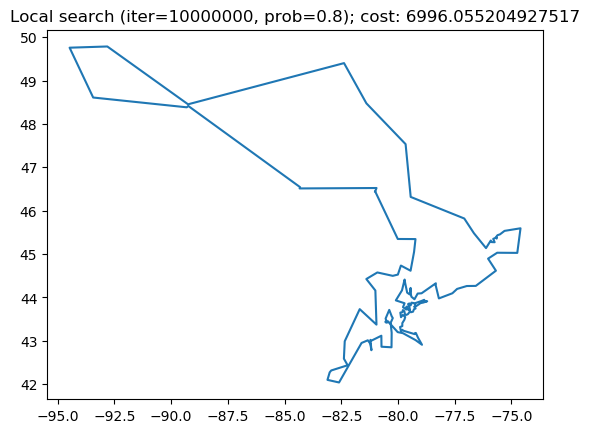

11.052933 seconds (33.91 M allocations: 15.035 GiB, 13.60% gc time)


PyObject Text(0.5, 1.0, 'Local search (iter=10000000, prob=0.8); cost: 6996.055204927517')

In [22]:
run(loc=loc, dist=dist, alg=alg_localsearch())

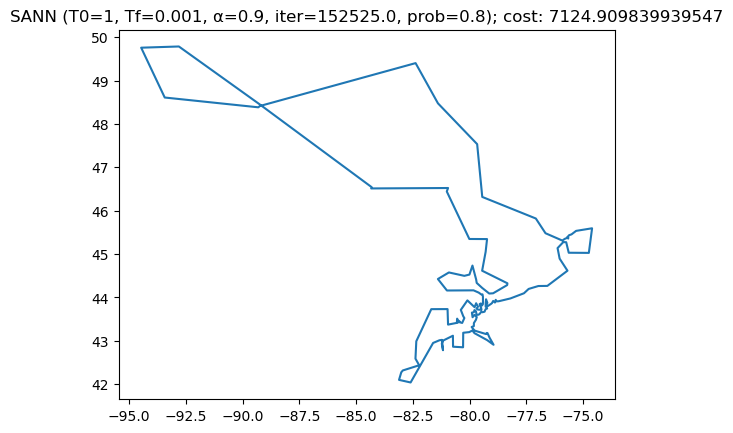

 11.500239 seconds (34.13 M allocations: 15.135 GiB, 15.77% gc time)


PyObject Text(0.5, 1.0, 'SANN (T0=1, Tf=0.001, α=0.9, iter=152525.0, prob=0.8); cost: 7124.909839939547')

In [23]:
run(loc=loc, dist=dist, alg=alg_sann())

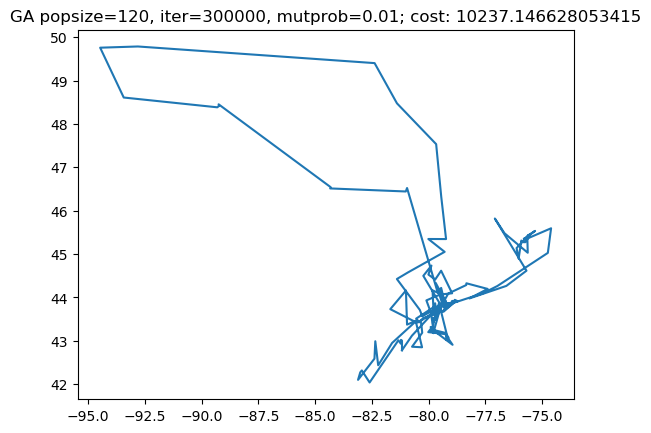

  6.068157 seconds (5.70 M allocations: 1.392 GiB, 5.38% gc time)


PyObject Text(0.5, 1.0, 'GA popsize=120, iter=300000, mutprob=0.01; cost: 10237.146628053415')

In [24]:
run(loc=loc, dist=dist, alg=alg_ga())

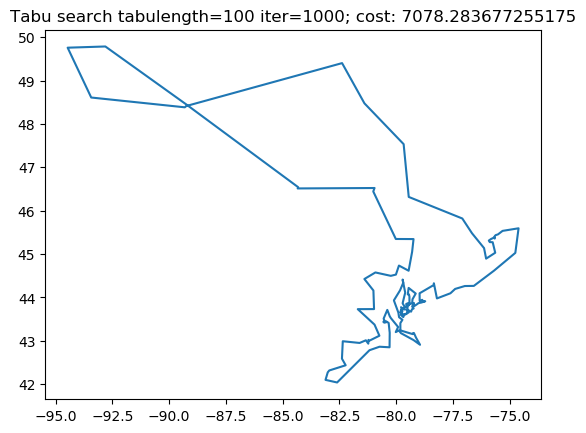

 16.054356 seconds (35.04 M allocations: 15.975 GiB, 19.57% gc time)


PyObject Text(0.5, 1.0, 'Tabu search tabulength=100 iter=1000; cost: 7078.283677255175')

In [25]:
run(loc=loc, dist=dist, alg=alg_tabusearch())